In [154]:
# Using clustering for preprocessing

from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

In [156]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [157]:
# baseline 
log_reg.score(X_test, y_test)

0.9733333333333334

In [158]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, n_init='auto', random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans',
                 KMeans(n_clusters=50, n_init='auto', random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [159]:
pipeline.score(X_test, y_test)

0.9888888888888889

In [160]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, n_init='auto',
                                               random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [161]:
grid_clf.best_params_

{'kmeans__n_clusters': 87}

In [162]:
grid_clf.score(X_test, y_test)

0.9866666666666667

In [163]:
# using clustering for semi-supervised learning

n_labeled = 50
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [164]:
log_reg.score(X_test, y_test)

0.84

In [165]:
import numpy as np
k = 50
kmeans = KMeans(n_clusters=k, n_init='auto', max_iter=5000, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

<function matplotlib.pyplot.show(close=None, block=None)>

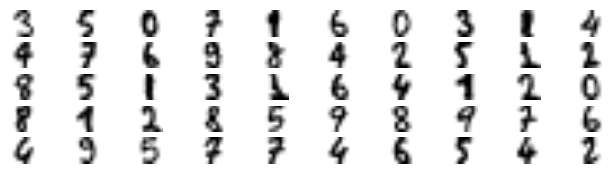

In [166]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
plt.show

In [167]:
# normally we should manually label those representative digits (i.e. semi-supervised learning) but we have cheated here, using the labels in y_train
y_representative_digits = y_train[representative_digit_idx]

In [168]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [169]:
log_reg.score(X_test, y_test)

0.9088888888888889

In [170]:
# propagate the labels
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [171]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.8955555555555555

In [172]:
# propagate the labels to only the 20% of the instances that are closest to the centroids

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]  # This is an array of distances from the instances to their cluster centroids
for i in range(k):
    in_cluster = (kmeans.labels_ == i)  # array of booleans indicating whether or not that instance is in the i-th cluster
    cluster_dist = X_cluster_dist[in_cluster]  # array of distances from instances in the i-th cluster to the i-th cluster centroid.
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)  # the distance that is at 20% of the distances in the array.
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1  # mark the instances in this cluster but beyong 20% distance cutoff to the centroid.

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [173]:
log_reg = LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9

In [174]:
# check how accurate the propagated labels are
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9688581314878892